In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from transformers import (
    AutoProcessor, 
    AutoModelForCausalLM, 
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from PIL import Image
from tqdm import tqdm
import os
import glob
import random
from huggingface_hub import login
login("YOUR_HF_TOKEN_HERE")
import albumentations as A
from albumentations.pytorch import ToTensorV2


2025-09-17 15:26:27.843681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758122788.207436      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758122788.311618      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4.1.4. Experiment B — Florence-2 as Classification: Methodology

In [2]:
class Config:
    # Model settings - Use Florence-2-large for better performance
    model_name = "microsoft/Florence-2-base-ft"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16
    
    # Improved LoRA Configuration
    lora_r = 64
    lora_alpha = 128
    lora_dropout = 0.07
    epochs = 10
    
    # Optimized Training settings
    batch_size = 16
    learning_rate = 5e-5
    num_epochs = 10
    
    # Enhanced Memory optimization
    dataloader_num_workers = 2


In [3]:
class FlorenceLoRAClassifier(nn.Module):
    def __init__(self, model_name, device, torch_dtype=torch.float16):
        super().__init__()

        # Load base Florence-2 (encoder-decoder VLM)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float32,
            trust_remote_code=True
        ).to(device)

        # LoRA configuration
        TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj"]
        lora_cfg = LoraConfig(
            r=Config.lora_r,
            lora_alpha=Config.lora_alpha,
            target_modules=TARGET_MODULES,
            task_type="CAUSAL_LM",
            lora_dropout=Config.lora_dropout,
            bias="none",
            inference_mode=False
        )
        self.model = get_peft_model(self.model, lora_cfg)
    def forward(self, pixel_values, input_ids=None, attention_mask=None, labels=None):
        # Standard Florence-2 forward pass for generation training
        outputs = self.model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,  # For generation loss
            return_dict=True
        )
        return outputs

    def generate(self, pixel_values, input_ids, **kwargs):
        # For inference generation
        return self.model.generate(
            pixel_values=pixel_values,
            input_ids=input_ids,
            **kwargs
        )

model = FlorenceLoRAClassifier(
    model_name=Config.model_name,
    device=Config.device,
    torch_dtype=torch.float32
)

processor = AutoProcessor.from_pretrained(Config.model_name, trust_remote_code=True)

config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/463M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [4]:

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
# for name, param in model.named_parameters():
#     if "lora" in name:
#         param.requires_grad = True
total, trainable = count_parameters(model)
print(f"Total parameters: {total/1e6:.2f}M")
print(f"Trainable (LoRA) parameters: {trainable/1e6:.2f}M")

Total parameters: 236.72M
Trainable (LoRA) parameters: 5.31M


4.1.1. Class Imbalance Mitigation and Data Augmentation

In [6]:
import os, glob, random
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os, glob, random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import os, glob, random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
class ClassificationAIDERDataset(Dataset):
    def __init__(self, dataset_root, processor, split="train",
                 train_ratio=0.5, val_ratio=0.2, use_table2=False, seed=42):
        self.processor = processor
        self.split = split
        self.use_table2 = use_table2
        self.seed = seed
        self.class_names = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}

        # Augmentation (applied only in training & non-normal classes)
        self.augment_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=30, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.CLAHE(p=0.2),
            A.RandomShadow(p=0.2),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        ]) if split == "train" else None

        # Load images with the chosen strategy
        self.images = self._load_images_with_splits(dataset_root, split, train_ratio, val_ratio)
        
        # Print distribution
        class_counts = {}
        for _, class_name in self.images:
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        print(f"📊 {split.upper()} Base Class Distribution:")
        for class_name, count in class_counts.items():
            aug_status = "❌ (No Aug)" if class_name == "normal" else "✅ (Augmented)"
            print(f"   {class_name}: {count} images {aug_status}")
        
        print(f"📊 {split.upper()} Dataset: {len(self.images)} base images")
        
        if split == "train":
            augmented_classes = [name for name in self.class_names if name != "normal"]
            print(f"🔄 Augmentation applied to: {', '.join(augmented_classes)}")
            print(f"🚫 No augmentation for: normal")

    def _load_images_with_splits(self, dataset_root, split, train_ratio=0.5, val_ratio=0.2):
        rng = random.Random(self.seed)

        # 🔹 Table 2 counts (Train + Test only, no validation)
        TARGET = {
            "collapsed_building": {"train": 367, "val": 41,  "test": 103},
            "fire":               {"train": 249, "val": 63,  "test": 209},
            "flooded_areas":      {"train": 252, "val": 63,  "test": 211},
            "traffic_incident":   {"train": 232, "val": 59,  "test": 194},
            "normal":             {"train": 2107,"val": 527, "test": 1756},
        }

        all_images_by_class = {}
        for class_name in self.class_names:
            class_path = os.path.join(dataset_root, class_name)
            if not os.path.exists(class_path):
                print(f"⚠️ Warning: {class_path} not found")
                continue

            # Collect images
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
            image_paths = []
            for ext in image_extensions:
                image_paths.extend(glob.glob(os.path.join(class_path, ext)))
                image_paths.extend(glob.glob(os.path.join(class_path, ext.upper())))
            
            rng.shuffle(image_paths)
            all_images_by_class[class_name] = image_paths
            print(f"📁 Found {len(image_paths)} images in {class_name}")

        split_data = []
        for class_name, image_paths in all_images_by_class.items():
            if self.use_table2:
                train_k = TARGET[class_name]["train"]
                val_k   = TARGET[class_name]["val"]
                test_k  = TARGET[class_name]["test"]
            
                if split == "train":
                    class_images = image_paths[:train_k]
                elif split == "val":
                    class_images = image_paths[train_k:train_k + val_k]
                else:  # test
                    class_images = image_paths[train_k + val_k:train_k + val_k + test_k]
            else:
                # Use ratio-based splitting
                total_images = len(image_paths)
                train_end = int(total_images * train_ratio)
                val_end = int(total_images * (train_ratio + val_ratio))
                print(f"traine end {train_end} and val end {val_end}")
                if split == "train":
                    class_images = image_paths[:train_end]
                elif split == "val":
                    class_images = image_paths[train_end:val_end]
                else:  # test
                    class_images = image_paths[val_end:]

            for img_path in class_images:
                split_data.append((img_path, class_name))
            
            print(f"📊 {class_name} - {split}: {len(class_images)} images")

        rng.shuffle(split_data)
        return split_data

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path, class_name = self.images[idx]
        image = Image.open(image_path).convert('RGB')

        should_augment = (
            self.split == "train" and 
            class_name != "normal" and 
            self.augment_transforms is not None
        )
        
        if should_augment:
            if not isinstance(image, np.ndarray):
                image = np.array(image)   # convert PIL.Image -> numpy
            augmented = self.augment_transforms(image=image)
            image = augmented["image"]
            if not hasattr(self, 'aug_counts'):
                self.aug_counts = {}
            self.aug_counts[class_name] = self.aug_counts.get(class_name, 0) + 1
        
        return {
            'image': image,
            'labels': self.class_to_idx[class_name],
            'class_name': class_name,
            'was_augmented': should_augment
        }


In [7]:
dataset_root = "/kaggle/input/aider2/AIDER"

# To match Table 2 exactly:
train_dataset = ClassificationAIDERDataset(dataset_root, processor, split="train", use_table2=True)
test_dataset  = ClassificationAIDERDataset(dataset_root, processor, split="test", use_table2=True)
val_dataset = ClassificationAIDERDataset(dataset_root, processor, split="val", use_table2=True)

📁 Found 511 images in collapsed_building
📁 Found 521 images in fire
📁 Found 526 images in flooded_areas
📁 Found 4390 images in normal
📁 Found 485 images in traffic_incident
📊 collapsed_building - train: 367 images
📊 fire - train: 249 images
📊 flooded_areas - train: 252 images
📊 normal - train: 2107 images
📊 traffic_incident - train: 232 images
📊 TRAIN Base Class Distribution:
   traffic_incident: 232 images ✅ (Augmented)
   collapsed_building: 367 images ✅ (Augmented)
   fire: 249 images ✅ (Augmented)
   normal: 2107 images ❌ (No Aug)
   flooded_areas: 252 images ✅ (Augmented)
📊 TRAIN Dataset: 3207 base images
🔄 Augmentation applied to: collapsed_building, fire, flooded_areas, traffic_incident
🚫 No augmentation for: normal
📁 Found 511 images in collapsed_building
📁 Found 521 images in fire
📁 Found 526 images in flooded_areas
📁 Found 4390 images in normal
📁 Found 485 images in traffic_incident
📊 collapsed_building - test: 103 images
📊 fire - test: 209 images
📊 flooded_areas - test: 211 

In [8]:
def get_class_completion(class_name):
    """Generate class-specific completion targets"""
    completions = {
        "collapsed_building": "This is a collapsed building scene",
        "fire": "This shows an active fire with visible flames and smoke", 
        "flooded_areas": "This is a flooded area scene",
        "normal": "This is a normal and undamaged scene.",
        "traffic_incident": "This depicts a traffic accident with damaged vehicles"
    }
    return completions[class_name]

def extract_class_from_completion_robust(generated_text):
    """Robust extraction that handles variations in generated text"""
    text = generated_text.lower().replace("<MORE_DETAILED_CAPTION>", "").strip()
    
    # Score-based approach with multiple patterns per class
    class_patterns = {
        1: {  # fire
            'primary': ['fire scene', 'fire'],
            'secondary': ['fire', 'burning', 'flames', 'smoke' , 'blaze'],
            'context': ['this is', 'shows', 'depicts']
        },
        0: {  # collapsed_building  
            'primary': ['collapsed building scene', 'building collapse'],
            'secondary': ['collapsed', 'destroyed building', 'building damage', 'structural damage'],
            'context': ['this is', 'shows', 'depicts']
        },
        2: {  # flooded_areas
            'primary': ['flooded area scene', 'flooding scene'],
            'secondary': ['flood', 'flooded', 'water damage', 'inundated'],
            'context': ['this is', 'shows', 'depicts']
        },
        4: {  # traffic_incident
            'primary': ['traffic incident scene', 'traffic accident'],
            'secondary': ['accident', 'crash', 'collision', 'vehicle damage', 'car damaged'],
            'context': ['this is', 'shows', 'depicts']
        },
        3: {  # normal (updated for polished prompt)
            'primary': ['normal', 'normal undamaged scene', 'undamaged scene'],
            'secondary': ['normal', 'regular', 'typical', 'ordinary', 'undamaged', 'no signs of', 'no disasters'],
            'context': ['this is', 'shows', 'depicts', 'a normal']
        }
    }
    
    class_scores = {}
    
    for class_idx, patterns in class_patterns.items():
        score = 0
        
        # High weight for primary patterns
        for pattern in patterns['primary']:
            if pattern in text:
                score += 3
        
        # Medium weight for secondary keywords
        for keyword in patterns['secondary']:
            if keyword in text:
                score += 2
        
        # Bonus for proper context (indicates it's a description)
        for context in patterns['context']:
            if context in text:
                score += 1
                break
        
        class_scores[class_idx] = score
    
    # Return class with highest score
    if max(class_scores.values()) > 0:
        return max(class_scores, key=class_scores.get)
    else:
        return 3  # default to normal

# Test different variations Florence-2 might generate
test_completions = [
    "<CAPTION>This is a fire scene",          # Exact match
    "<CAPTION>This shows a fire",             # Variation
    "<CAPTION>This depicts a burning building", # Different wording
    "<CAPTION>This is a building fire scene", # Extra words
    "<CAPTION>Scene shows crash incidents ", # Different order
]

for completion in test_completions:
    result = extract_class_from_completion_robust(completion)
    print(f"'{completion}' → Class {result}")




'<CAPTION>This is a fire scene' → Class 1
'<CAPTION>This shows a fire' → Class 1
'<CAPTION>This depicts a burning building' → Class 1
'<CAPTION>This is a building fire scene' → Class 1
'<CAPTION>Scene shows crash incidents ' → Class 4


4.1.4. Experiment B — Florence-2 as Classification: Methodology

In [9]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from torch.nn.utils.rnn import pad_sequence

def make_collate_fn(processor):
    def collate(batch):
        images = [item['image'] for item in batch]
        
        # Input prompts (same for all)
        input_prompts = ['<MORE_DETAILED_CAPTION>'] * len(images)
        
        # Target completions (class-specific)
        target_completions = []
        for item in batch:
            class_name = item['class_name']  # You need this in dataset
            completion = get_class_completion(class_name)
            target_completions.append(f"<MORE_DETAILED_CAPTION>{completion}")
        
        # Process inputs and targets
        inputs = processor(images=images, text=input_prompts, return_tensors="pt", padding=True)
        # ✅ Process targets using tokenizer only (no images needed)
        targets = processor.tokenizer(
            target_completions, 
            return_tensors="pt", 
            padding=True,
            truncation=True
        )
        
        return {
            'pixel_values': inputs['pixel_values'],
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs.get('attention_mask'),
            'labels': targets['input_ids'],  # ✅ Class-specific completions
            'class_labels': torch.tensor([item['labels'] for item in batch], dtype=torch.long),
            'images': images  # Keep for evaluation
        }
    
    return collate


# Count each class occurrence
labels = [int(sample["labels"]) for sample in train_dataset]
classes = np.unique(labels)
print(f"num of classess{classes}")
class_counts = np.array([(labels == c).sum() for c in classes], dtype=np.int64)

class_weight = {c: 1.0 / cnt for c, cnt in zip(classes, class_counts)}

sample_weights = np.array([class_weight[int(l)] for l in labels], dtype=np.float64)

# Create sampler
sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(sample_weights),
    replacement=True
)
collate_fn = make_collate_fn(processor)
# DataLoader with sampler
train_loader = DataLoader(
    train_dataset,
    sampler=sampler,
    shuffle=False,  # ✅ keep order
    batch_size=Config.batch_size,  # ✅ allowed here
    collate_fn=collate_fn,
    num_workers=Config.dataloader_num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,  # ✅ keep order
    collate_fn=collate_fn,
    num_workers=Config.dataloader_num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=Config.batch_size,
    shuffle=False, 
    collate_fn=collate_fn
)

num of classess[0 1 2 3 4]


In [21]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch, time
from tqdm import tqdm

def evaluate_completion_model_with_metrics(model, val_loader, processor):
    """Evaluate model with robust extraction, metrics, sample visualization, and timing"""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device) 
    y_true, y_pred = [], []
    correct_samples, wrong_samples = [], []  # store examples

    print("\n🔍 Evaluating with robust extraction and comprehensive metrics...")
    start_time = time.time()
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            batch_size = batch['class_labels'].size(0)
            
            for i in range(batch_size):
                total_samples += 1
                try:
                    # Generate completion
                    inputs = processor(
                        text="<MORE_DETAILED_CAPTION>",
                        images=[batch['images'][i]],
                        return_tensors="pt"
                    ).to(device)
                    
                    generated_ids = model.generate(
                        pixel_values=inputs['pixel_values'],
                        input_ids=inputs['input_ids'],
                        max_new_tokens=50,
                        do_sample=False,
                        num_beams=10,
                        pad_token_id=processor.tokenizer.pad_token_id,
                        eos_token_id=processor.tokenizer.eos_token_id 
                    )
                    
                    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                    predicted_class = extract_class_from_completion_robust(generated_text)
                    true_class = int(batch['class_labels'][i])
                    
                except Exception as e:
                    predicted_class = 3  # fallback to "normal"
                    true_class = int(batch['class_labels'][i])
                
                # Append results
                y_true.append(true_class)
                y_pred.append(predicted_class)

                # Save samples (only up to 4 each)
                # Save samples (only up to 4 each)
                img = batch['images'][i]
                
                # Convert to numpy if it's a tensor
                if isinstance(img, torch.Tensor):
                    img = img.cpu().permute(1, 2, 0).numpy()
                
                if predicted_class == true_class and len(correct_samples) < 4:
                    correct_samples.append((img, true_class, predicted_class))
                elif predicted_class != true_class and len(wrong_samples) < 4:
                    wrong_samples.append((img, true_class, predicted_class))


    # --- Metrics ---
    total_time = time.time() - start_time
    avg_time = total_time / max(total_samples, 1)

    accuracy = 100 * sum([int(t==p) for t,p in zip(y_true, y_pred)]) / max(len(y_true), 1)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    cm = confusion_matrix(y_true, y_pred)

    class_names = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]

    print(f"\n📊 COMPREHENSIVE EVALUATION RESULTS:")
    print(f"🎯 Accuracy: {accuracy:.2f}% ({sum([int(t==p) for t,p in zip(y_true, y_pred)])}/{len(y_true)})")
    print(f"📈 Weighted F1 Score: {f1_weighted:.4f}")
    print(f"📈 Macro F1 Score: {f1_macro:.4f}")
    print(f"📈 Micro F1 Score: {f1_micro:.4f}")
    print(f"⏱️ Avg Processing Time per Sample: {avg_time:.4f} sec")

    print(f"\n🔍 CONFUSION MATRIX:")
    print("    ", " ".join([f"{name[:4]:>6}" for name in class_names]))
    for i, row in enumerate(cm):
        print(f"{class_names[i][:4]:>4}", " ".join([f"{val:>6}" for val in row]))
    
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # --- Confusion Matrix Plot ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # --- Visualization of correct & wrong predictions ---
    def plot_samples(samples, title):
        if samples:
            fig, axes = plt.subplots(1, len(samples), figsize=(16, 4))
            for ax, (img, true_c, pred_c) in zip(axes, samples):
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(f"T:{class_names[true_c]}\nP:{class_names[pred_c]}", fontsize=10)
            plt.suptitle(title)
            plt.show()

    plot_samples(correct_samples, "✅ Correct Predictions")
    plot_samples(wrong_samples, "❌ Wrong Predictions")

    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'avg_time_per_sample': avg_time
    }


In [10]:
from torch.optim import AdamW
from transformers import get_scheduler


optimizer = AdamW(model.parameters(), lr=Config.learning_rate)
num_training_steps = Config.epochs * len(train_loader)
from transformers import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps,
    num_cycles=0.5
)

🚀 Starting training with full training dataset accuracy evaluation...

📚 Training Epoch 1/10


Epoch 1: 100%|██████████| 201/201 [12:25<00:00,  3.71s/it, loss=0.3957, step=201]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set: 100%|██████████| 201/201 [05:34<00:00,  1.66s/it]


📊 Full Training Accuracy: 83.83% (420/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<08:18, 10.62s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This depicts a traffic accident with damaged vehicles'
True: normal | Predicted: traffic_incident
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
-----------------------------------

Evaluating: 100%|██████████| 48/48 [06:48<00:00,  8.52s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 85.79% (646/753)
📈 Weighted F1 Score: 0.8198
📈 Macro F1 Score: 0.6807
📈 Micro F1 Score: 0.8579

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     37      0      0      4      0
fire      1      0      0     62      0
floo      0      0     52     11      0
norm      3      0      2    511     11
traf      8      0      2      3     46

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.7551    0.9024    0.8222        41
              fire     0.0000    0.0000    0.0000        63
     flooded_areas     0.9286    0.8254    0.8739        63
            normal     0.8646    0.9696    0.9141       527
  traffic_incident     0.8070    0.7797    0.7931        59

          accuracy                         0.8579       753
         macro avg     0.6711    0.6954    0.6807       753
      weighted avg     0.7872    0.8579    0.8198       753



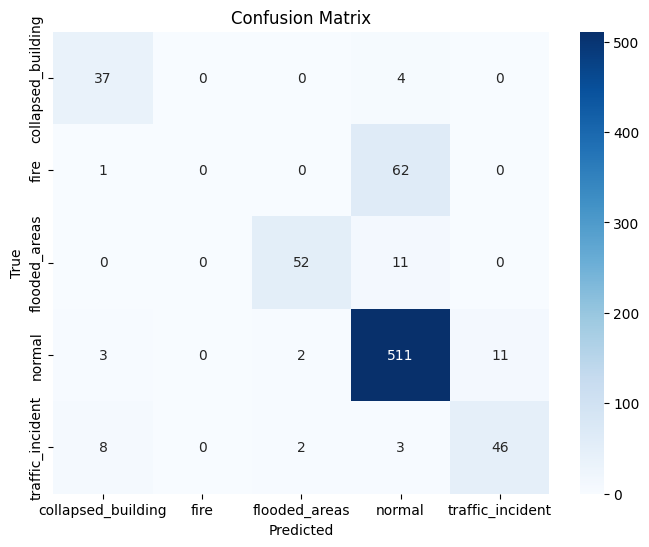


Epoch 1 Complete Results:
  📊 Training Loss: 2.1322
  🎯 Training Accuracy (Full): 83.83%
  🎯 Validation Accuracy: 85.79%
  📈 Weighted F1 Score: 0.8198
  📊 Train-Val Gap: -1.96%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 83.83%, Val: 85.79%

📚 Training Epoch 2/10


Epoch 2:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 2: 100%|██████████| 201/201 [12:28<00:00,  3.72s/it, loss=0.2594, step=402]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:33<00:00,  1.66s/it]


📊 Full Training Accuracy: 91.02% (456/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This depicts a traffic accident with damaged vehicles'
True: normal | Predicted: traffic_incident
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DET

Evaluating:   2%|▏         | 1/48 [00:10<08:08, 10.39s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated:

Evaluating: 100%|██████████| 48/48 [06:46<00:00,  8.46s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 91.77% (691/753)
📈 Weighted F1 Score: 0.9153
📈 Macro F1 Score: 0.8581
📈 Micro F1 Score: 0.9177

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     32      1      0      7      1
fire      0     56      0      7      0
floo      0      0     40     20      3
norm      2      0      0    513     12
traf      2      0      0      7     50

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.8889    0.7805    0.8312        41
              fire     0.9825    0.8889    0.9333        63
     flooded_areas     1.0000    0.6349    0.7767        63
            normal     0.9260    0.9734    0.9491       527
  traffic_incident     0.7576    0.8475    0.8000        59

          accuracy                         0.9177       753
         macro avg     0.9110    0.8250    0.8581       753
      weighted avg     0.9217    0.9177    0.9153       753



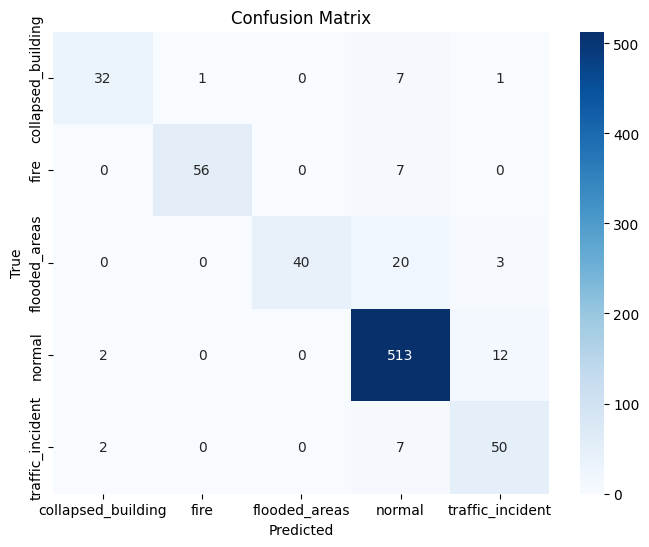


Epoch 2 Complete Results:
  📊 Training Loss: 0.2965
  🎯 Training Accuracy (Full): 91.02%
  🎯 Validation Accuracy: 91.77%
  📈 Weighted F1 Score: 0.9153
  📊 Train-Val Gap: -0.75%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 91.02%, Val: 91.77%

📚 Training Epoch 3/10


Epoch 3:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 3: 100%|██████████| 201/201 [12:28<00:00,  3.72s/it, loss=0.2398, step=603]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:26<00:00,  1.63s/it]


📊 Full Training Accuracy: 94.61% (474/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<08:00, 10.22s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: normal | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
G

Evaluating: 100%|██████████| 48/48 [06:43<00:00,  8.41s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 94.02% (708/753)
📈 Weighted F1 Score: 0.9374
📈 Macro F1 Score: 0.8933
📈 Micro F1 Score: 0.9402

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     37      1      0      3      0
fire      0     60      0      3      0
floo      0      0     45     18      0
norm      3      0      0    524      0
traf      4      0      0     13     42

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.8409    0.9024    0.8706        41
              fire     0.9836    0.9524    0.9677        63
     flooded_areas     1.0000    0.7143    0.8333        63
            normal     0.9340    0.9943    0.9632       527
  traffic_incident     1.0000    0.7119    0.8317        59

          accuracy                         0.9402       753
         macro avg     0.9517    0.8551    0.8933       753
      weighted avg     0.9438    0.9402    0.9374       753



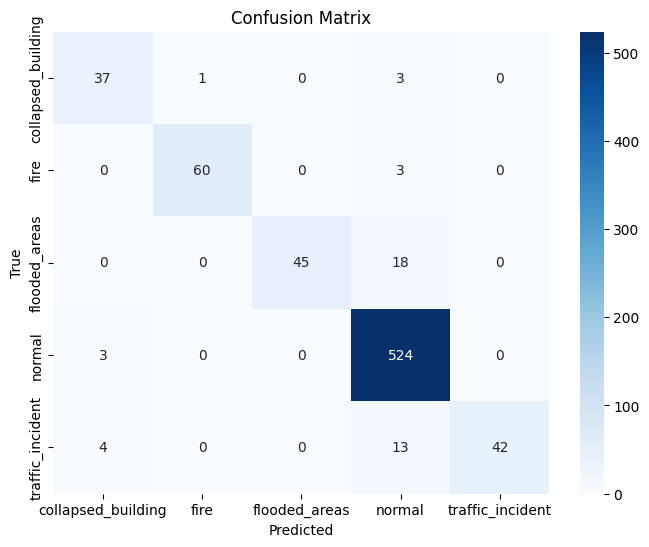


Epoch 3 Complete Results:
  📊 Training Loss: 0.2633
  🎯 Training Accuracy (Full): 94.61%
  🎯 Validation Accuracy: 94.02%
  📈 Weighted F1 Score: 0.9374
  📊 Train-Val Gap: 0.59%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 94.61%, Val: 94.02%

📚 Training Epoch 4/10


Epoch 4:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 4: 100%|██████████| 201/201 [12:28<00:00,  3.72s/it, loss=0.2330, step=804]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:27<00:00,  1.63s/it]


📊 Full Training Accuracy: 94.81% (475/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<08:01, 10.24s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated:

Evaluating: 100%|██████████| 48/48 [06:43<00:00,  8.41s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 94.82% (714/753)
📈 Weighted F1 Score: 0.9461
📈 Macro F1 Score: 0.9071
📈 Micro F1 Score: 0.9482

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     37      1      0      3      0
fire      0     60      0      3      0
floo      0      0     49     14      0
norm      2      0      0    525      0
traf      4      0      0     12     43

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.8605    0.9024    0.8810        41
              fire     0.9836    0.9524    0.9677        63
     flooded_areas     1.0000    0.7778    0.8750        63
            normal     0.9425    0.9962    0.9686       527
  traffic_incident     1.0000    0.7288    0.8431        59

          accuracy                         0.9482       753
         macro avg     0.9573    0.8715    0.9071       753
      weighted avg     0.9508    0.9482    0.9461       753



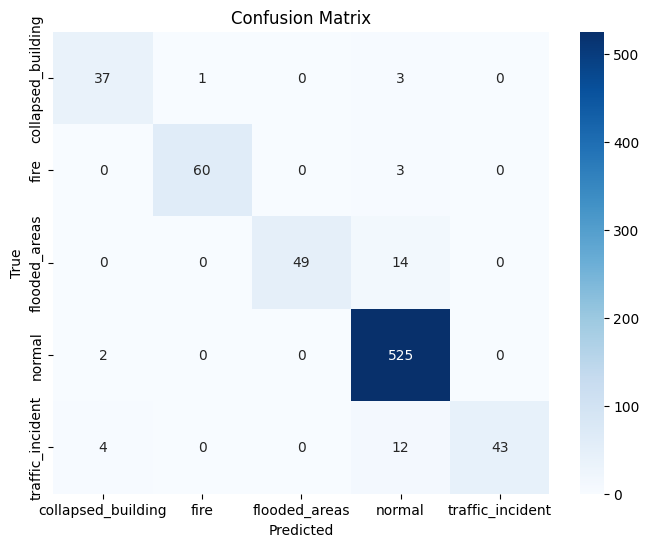


Epoch 4 Complete Results:
  📊 Training Loss: 0.2551
  🎯 Training Accuracy (Full): 94.81%
  🎯 Validation Accuracy: 94.82%
  📈 Weighted F1 Score: 0.9461
  📊 Train-Val Gap: -0.01%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 94.81%, Val: 94.82%

📚 Training Epoch 5/10


Epoch 5:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 5: 100%|██████████| 201/201 [12:26<00:00,  3.72s/it, loss=0.2300, step=1005]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:27<00:00,  1.63s/it]


📊 Full Training Accuracy: 96.21% (482/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<07:57, 10.17s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: normal | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
G

Evaluating: 100%|██████████| 48/48 [06:42<00:00,  8.38s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 95.88% (722/753)
📈 Weighted F1 Score: 0.9581
📈 Macro F1 Score: 0.9300
📈 Micro F1 Score: 0.9588

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     37      0      0      3      1
fire      0     59      0      3      1
floo      0      0     53     10      0
norm      3      0      0    523      1
traf      1      0      0      8     50

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9024    0.9024    0.9024        41
              fire     1.0000    0.9365    0.9672        63
     flooded_areas     1.0000    0.8413    0.9138        63
            normal     0.9561    0.9924    0.9739       527
  traffic_incident     0.9434    0.8475    0.8929        59

          accuracy                         0.9588       753
         macro avg     0.9604    0.9040    0.9300       753
      weighted avg     0.9595    0.9588    0.9581       753



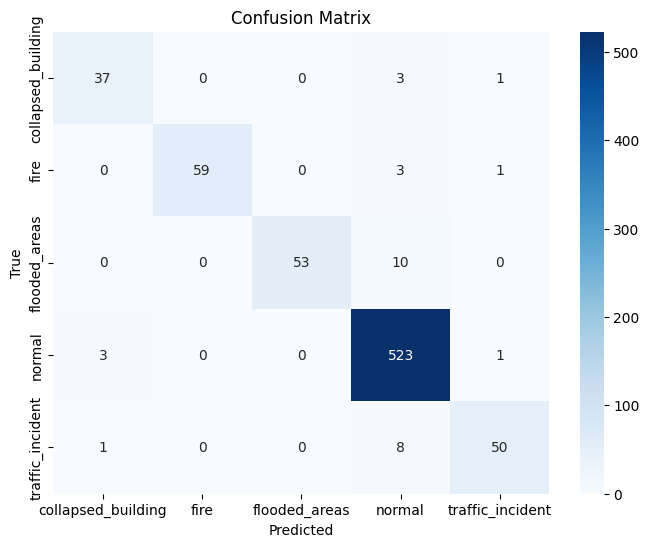


Epoch 5 Complete Results:
  📊 Training Loss: 0.2503
  🎯 Training Accuracy (Full): 96.21%
  🎯 Validation Accuracy: 95.88%
  📈 Weighted F1 Score: 0.9581
  📊 Train-Val Gap: 0.32%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 96.21%, Val: 95.88%

📚 Training Epoch 6/10


Epoch 6:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 6: 100%|██████████| 201/201 [12:27<00:00,  3.72s/it, loss=0.2282, step=1206]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:26<00:00,  1.63s/it]


📊 Full Training Accuracy: 96.41% (483/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<07:56, 10.13s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated:

Evaluating: 100%|██████████| 48/48 [06:41<00:00,  8.37s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 95.09% (716/753)
📈 Weighted F1 Score: 0.9486
📈 Macro F1 Score: 0.9132
📈 Micro F1 Score: 0.9509

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     36      0      0      4      1
fire      0     59      0      3      1
floo      0      0     53     10      0
norm      0      0      0    527      0
traf      2      0      0     16     41

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9474    0.8780    0.9114        41
              fire     1.0000    0.9365    0.9672        63
     flooded_areas     1.0000    0.8413    0.9138        63
            normal     0.9411    1.0000    0.9696       527
  traffic_incident     0.9535    0.6949    0.8039        59

          accuracy                         0.9509       753
         macro avg     0.9684    0.8701    0.9132       753
      weighted avg     0.9522    0.9509    0.9486       753



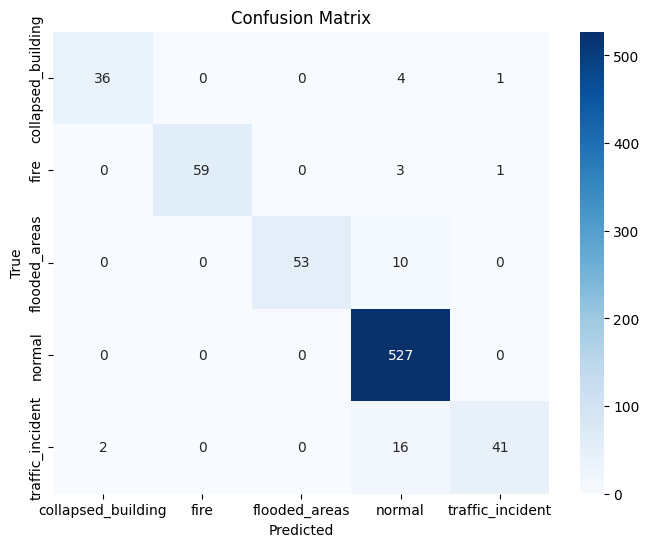


Epoch 6 Complete Results:
  📊 Training Loss: 0.2476
  🎯 Training Accuracy (Full): 96.41%
  🎯 Validation Accuracy: 95.09%
  📈 Weighted F1 Score: 0.9486
  📊 Train-Val Gap: 1.32%
✅ Excellent generalization (<2% gap)

📚 Training Epoch 7/10


Epoch 7:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 7: 100%|██████████| 201/201 [12:27<00:00,  3.72s/it, loss=0.2271, step=1407]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:26<00:00,  1.62s/it]


📊 Full Training Accuracy: 97.01% (486/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<08:03, 10.28s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated:

Evaluating: 100%|██████████| 48/48 [06:42<00:00,  8.38s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 96.15% (724/753)
📈 Weighted F1 Score: 0.9601
📈 Macro F1 Score: 0.9301
📈 Micro F1 Score: 0.9615

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     37      0      0      3      1
fire      0     61      0      2      0
floo      0      0     56      7      0
norm      1      0      0    526      0
traf      3      0      0     12     44

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9024    0.9024    0.9024        41
              fire     1.0000    0.9683    0.9839        63
     flooded_areas     1.0000    0.8889    0.9412        63
            normal     0.9564    0.9981    0.9768       527
  traffic_incident     0.9778    0.7458    0.8462        59

          accuracy                         0.9615       753
         macro avg     0.9673    0.9007    0.9301       753
      weighted avg     0.9624    0.9615    0.9601       753



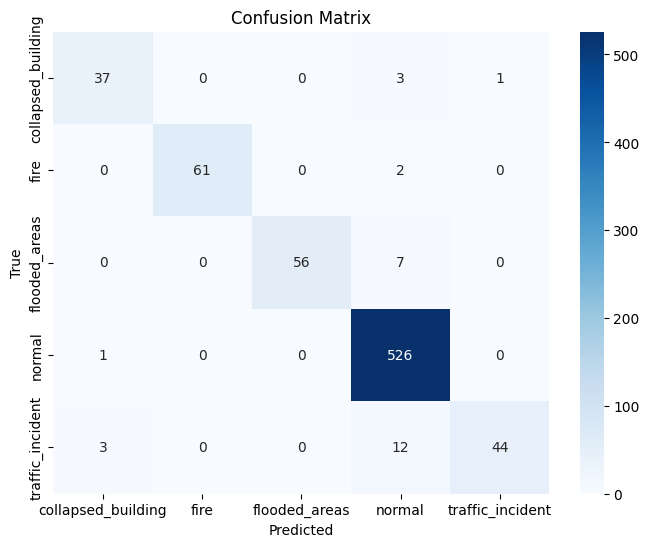


Epoch 7 Complete Results:
  📊 Training Loss: 0.2464
  🎯 Training Accuracy (Full): 97.01%
  🎯 Validation Accuracy: 96.15%
  📈 Weighted F1 Score: 0.9601
  📊 Train-Val Gap: 0.86%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 97.01%, Val: 96.15%

📚 Training Epoch 8/10


Epoch 8:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 8: 100%|██████████| 201/201 [12:27<00:00,  3.72s/it, loss=0.2328, step=1608]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:27<00:00,  1.63s/it]


📊 Full Training Accuracy: 97.41% (488/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<07:58, 10.18s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: normal | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '

Evaluating: 100%|██████████| 48/48 [06:43<00:00,  8.42s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 96.28% (725/753)
📈 Weighted F1 Score: 0.9619
📈 Macro F1 Score: 0.9321
📈 Micro F1 Score: 0.9628

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     36      1      0      3      1
fire      0     61      0      2      0
floo      0      0     58      5      0
norm      1      1      2    523      0
traf      2      0      1      9     47

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9231    0.8780    0.9000        41
              fire     0.9683    0.9683    0.9683        63
     flooded_areas     0.9508    0.9206    0.9355        63
            normal     0.9649    0.9924    0.9785       527
  traffic_incident     0.9792    0.7966    0.8785        59

          accuracy                         0.9628       753
         macro avg     0.9573    0.9112    0.9321       753
      weighted avg     0.9629    0.9628    0.9619       753



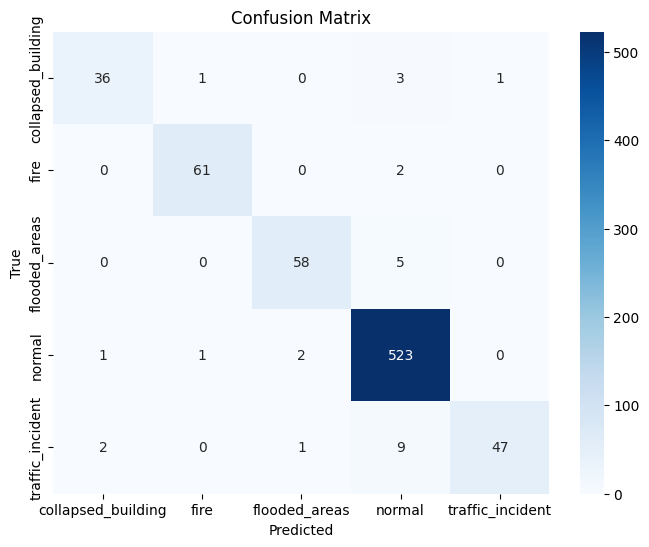


Epoch 8 Complete Results:
  📊 Training Loss: 0.2456
  🎯 Training Accuracy (Full): 97.41%
  🎯 Validation Accuracy: 96.28%
  📈 Weighted F1 Score: 0.9619
  📊 Train-Val Gap: 1.12%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 97.41%, Val: 96.28%

📚 Training Epoch 9/10


Epoch 9:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 9: 100%|██████████| 201/201 [12:30<00:00,  3.73s/it, loss=0.2274, step=1809]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:29<00:00,  1.64s/it]


📊 Full Training Accuracy: 96.41% (483/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<07:58, 10.18s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: normal | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '

Evaluating: 100%|██████████| 48/48 [06:43<00:00,  8.40s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 96.95% (730/753)
📈 Weighted F1 Score: 0.9690
📈 Macro F1 Score: 0.9461
📈 Micro F1 Score: 0.9695

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     37      1      0      2      1
fire      0     62      0      1      0
floo      0      0     58      5      0
norm      1      2      2    522      0
traf      1      0      1      6     51

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9487    0.9024    0.9250        41
              fire     0.9538    0.9841    0.9688        63
     flooded_areas     0.9508    0.9206    0.9355        63
            normal     0.9739    0.9905    0.9821       527
  traffic_incident     0.9808    0.8644    0.9189        59

          accuracy                         0.9695       753
         macro avg     0.9616    0.9324    0.9461       753
      weighted avg     0.9694    0.9695    0.9690       753



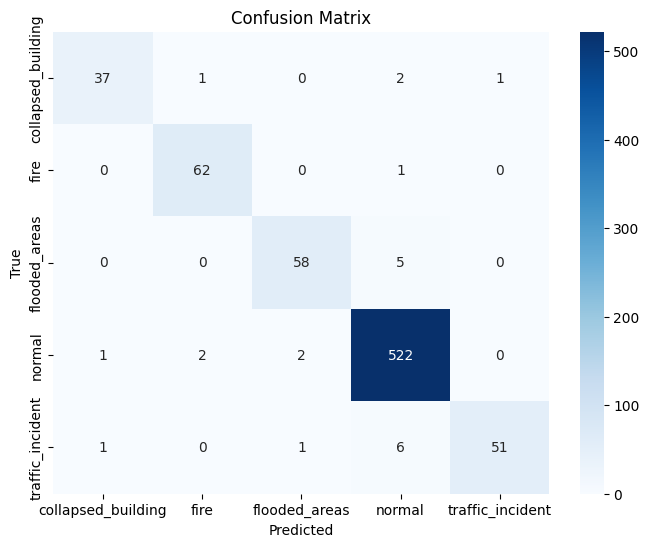


Epoch 9 Complete Results:
  📊 Training Loss: 0.2451
  🎯 Training Accuracy (Full): 96.41%
  🎯 Validation Accuracy: 96.95%
  📈 Weighted F1 Score: 0.9690
  📊 Train-Val Gap: -0.54%
✅ Excellent generalization (<2% gap)
🔥 New best model saved! Train: 96.41%, Val: 96.95%

📚 Training Epoch 10/10


Epoch 10:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 10: 100%|██████████| 201/201 [12:27<00:00,  3.72s/it, loss=0.2287, step=2010]


🧮 Calculating accuracy on 500 sample of training dataset...


Evaluating Training Set:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Training Set: 100%|██████████| 201/201 [05:29<00:00,  1.64s/it]


📊 Full Training Accuracy: 96.81% (485/501)
🔍 Evaluating on validation set...

🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<08:03, 10.28s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: normal | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '

Evaluating: 100%|██████████| 48/48 [06:42<00:00,  8.39s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 96.55% (727/753)
📈 Weighted F1 Score: 0.9648
📈 Macro F1 Score: 0.9387
📈 Micro F1 Score: 0.9655

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     36      1      0      3      1
fire      0     61      0      2      0
floo      0      0     58      5      0
norm      1      1      2    523      0
traf      1      0      1      8     49

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9474    0.8780    0.9114        41
              fire     0.9683    0.9683    0.9683        63
     flooded_areas     0.9508    0.9206    0.9355        63
            normal     0.9667    0.9924    0.9794       527
  traffic_incident     0.9800    0.8305    0.8991        59

          accuracy                         0.9655       753
         macro avg     0.9626    0.9180    0.9387       753
      weighted avg     0.9655    0.9655    0.9648       753



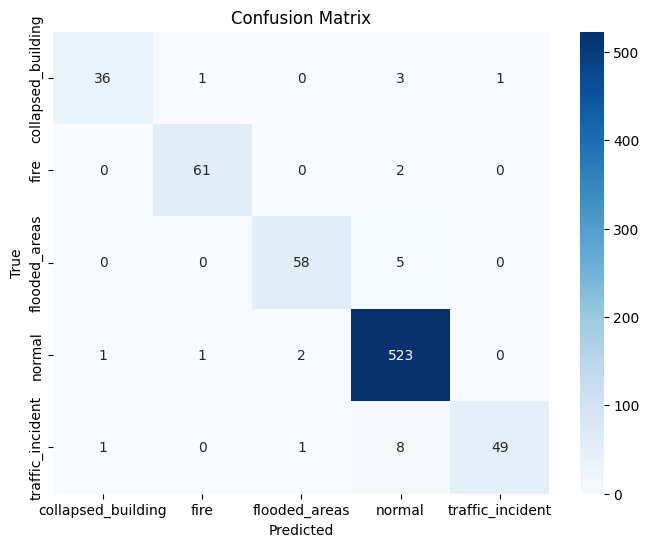


Epoch 10 Complete Results:
  📊 Training Loss: 0.2448
  🎯 Training Accuracy (Full): 96.81%
  🎯 Validation Accuracy: 96.55%
  📈 Weighted F1 Score: 0.9648
  📊 Train-Val Gap: 0.26%
✅ Excellent generalization (<2% gap)

🎊 Training completed! Best F1: 0.9690


In [11]:
def calculate_full_training_accuracy(model, train_loader, processor):
    """Calculate training accuracy on the ENTIRE training dataset"""
    model.eval()
    correct = 0
    total = 0
    
    print("🧮 Calculating accuracy on 500 sample of training dataset...")
    
    with torch.no_grad():
        for batch in tqdm(train_loader, desc="Evaluating Training Set"):
            batch_size = batch['class_labels'].size(0)
            
            for i in range(batch_size):
                if total>500:
                    break
                try:
                    # Generate completion
                    inputs = processor(
                        text="<MORE_DETAILED_CAPTION>",
                        images=[batch['images'][i]],
                        return_tensors="pt"
                    ).to('cuda')
                    
                    generated_ids = model.generate(
                        pixel_values=inputs['pixel_values'],
                        input_ids=inputs['input_ids'],
                        max_new_tokens=150,
                        do_sample=False,
                        num_beams=10,
                        pad_token_id=processor.tokenizer.pad_token_id,
                        eos_token_id=processor.tokenizer.eos_token_id 
                    )
                    
                    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                    predicted_class = extract_class_from_completion_robust(generated_text)
                    true_class = int(batch['class_labels'][i])
                    
                    if predicted_class == true_class:
                        correct += 1
                    total += 1
                    
                except Exception:
                    total += 1
    
    model.train()  # Return to training mode
    accuracy = 100 * correct / max(total, 1)
    print(f"📊 Full Training Accuracy: {accuracy:.2f}% ({correct}/{total})")
    return accuracy
def train_completion_model_with_full_training_accuracy():
    best_val_f1 = 0.0
    best_val_acc = 0.0
    global_step = 0
    checkpoint_every = 500
    
    print("🚀 Starting training with full training dataset accuracy evaluation...")
    
    for epoch in range(Config.epochs):
        model.train()
        running_loss = 0
        
        print(f"\n📚 Training Epoch {epoch+1}/{Config.epochs}")
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            outputs = model(
                pixel_values=batch['pixel_values'].to('cuda', dtype=torch.float32),
                input_ids=batch['input_ids'].to('cuda'),
                attention_mask=batch['attention_mask'].to('cuda') if batch['attention_mask'] is not None else None,
                labels=batch['labels'].to('cuda')
            )
            
            loss = outputs.loss
            loss.backward()
            running_loss += loss.item()
            
            optimizer.step()
            lr_scheduler.step()
            global_step += 1
            
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}", 'step': global_step})
        
        # ✅ Calculate training accuracy on FULL dataset
        train_accuracy = calculate_full_training_accuracy(model, train_loader, processor)
        
        # Validation evaluation
        print("🔍 Evaluating on validation set...")
        results = evaluate_completion_model_with_metrics(model, val_loader, processor)
        
        print(f"\nEpoch {epoch+1} Complete Results:")
        print(f"  📊 Training Loss: {running_loss/len(train_loader):.4f}")
        print(f"  🎯 Training Accuracy (Full): {train_accuracy:.2f}%")  # ✅ Full dataset
        print(f"  🎯 Validation Accuracy: {results['accuracy']:.2f}%")
        print(f"  📈 Weighted F1 Score: {results['f1_weighted']:.4f}")
        print(f"  📊 Train-Val Gap: {train_accuracy - results['accuracy']:.2f}%")
        
        # Enhanced overfitting detection
        gap = train_accuracy - results['accuracy']
        if gap > 15:
            print("🚨 Strong overfitting detected! (>15% gap)")
        elif gap > 8:
            print("⚠️  Mild overfitting detected (>8% gap)")
        elif gap < 2:
            print("✅ Excellent generalization (<2% gap)")
        else:
            print("✅ Good generalization")
        
        # Save best model
        if results['f1_weighted'] > best_val_f1:
            best_val_f1 = results['f1_weighted']
            best_val_acc = results['accuracy']
            
            checkpoint_dir = f"./florence2-disaster-best-f1-{results['f1_weighted']:.4f}"
            os.makedirs(checkpoint_dir, exist_ok=True)
            
            model.save_pretrained(checkpoint_dir)
            processor.save_pretrained(checkpoint_dir)
            
            # Save with full training accuracy
            torch.save({
                'epoch': epoch + 1,
                'best_f1': best_val_f1,
                'best_acc': best_val_acc,
                'full_train_acc': train_accuracy,  # ✅ Full training accuracy
                'train_val_gap': gap,  # ✅ Overfitting metric
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'loss': running_loss/len(train_loader),
                'training_config': {
                    'learning_rate': Config.learning_rate,
                    'batch_size': Config.batch_size,
                    'lora_r': Config.lora_r,
                    'lora_alpha': Config.lora_alpha,
                    'epochs': Config.epochs
                },
                'metrics': results
            }, os.path.join(checkpoint_dir, 'training_state.pt'))
            
            print(f"🔥 New best model saved! Train: {train_accuracy:.2f}%, Val: {results['accuracy']:.2f}%")
    
    print(f"\n🎊 Training completed! Best F1: {best_val_f1:.4f}")
    return best_val_f1, best_val_acc
best_val_f1, best_val_acc = train_completion_model_with_full_training_accuracy()


🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Generated: '<MORE_DETAILED_CAPTION>This shows an active fire with visible flames and smoke'
True: fire | Predicted: fire
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>Thi

Evaluating:   1%|          | 1/155 [00:09<23:07,  9.01s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This depicts a traffic accident with damaged vehicles'
True: traffic_incident | Predicted: traffic_incident
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This shows an active fire with visible flames and smoke'
True: fire | Predicted: fire
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Ge

Evaluating: 100%|██████████| 155/155 [23:32<00:00,  9.12s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 97.09% (2401/2473)
📈 Weighted F1 Score: 0.9705
📈 Macro F1 Score: 0.9482
📈 Micro F1 Score: 0.9709

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     97      1      0      5      0
fire      0    206      0      3      0
floo      1      1    188     20      1
norm      3      2      6   1740      5
traf      4      2      0     18    170

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9238    0.9417    0.9327       103
              fire     0.9717    0.9856    0.9786       209
     flooded_areas     0.9691    0.8910    0.9284       211
            normal     0.9742    0.9909    0.9825      1756
  traffic_incident     0.9659    0.8763    0.9189       194

          accuracy                         0.9709      2473
         macro avg     0.9609    0.9371    0.9482      2473
      weighted avg     0.9708    0.9709    0.9705      2473



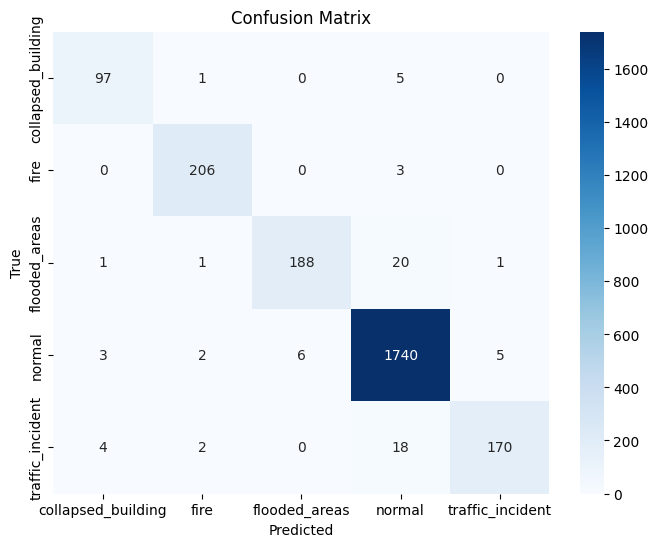

In [12]:
results = evaluate_completion_model_with_metrics(model, test_loader, processor)


🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: flooded_areas | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a no

Evaluating:   2%|▏         | 1/48 [00:10<07:57, 10.16s/it]

Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
True: normal | Predicted: flooded_areas
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a normal and undamaged scene.'
True: normal | Predicted: normal
--------------------------------------------------
Generated: '<MORE_DETAILED_CAPTION>This is a collapsed building scene'
True: collapsed_building | Predicted: collapsed_building
--------------------------------------------------
Generated: '

Evaluating: 100%|██████████| 48/48 [06:43<00:00,  8.40s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 96.55% (727/753)
📈 Weighted F1 Score: 0.9648
📈 Macro F1 Score: 0.9387
📈 Micro F1 Score: 0.9655

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     36      1      0      3      1
fire      0     61      0      2      0
floo      0      0     58      5      0
norm      1      1      2    523      0
traf      1      0      1      8     49

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9474    0.8780    0.9114        41
              fire     0.9683    0.9683    0.9683        63
     flooded_areas     0.9508    0.9206    0.9355        63
            normal     0.9667    0.9924    0.9794       527
  traffic_incident     0.9800    0.8305    0.8991        59

          accuracy                         0.9655       753
         macro avg     0.9626    0.9180    0.9387       753
      weighted avg     0.9655    0.9655    0.9648       753



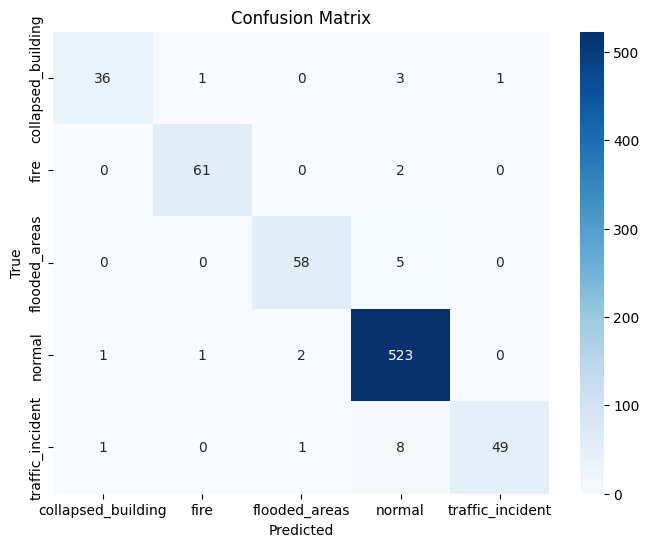

In [13]:
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,  # ✅ keep order
    collate_fn=collate_fn,
    num_workers=Config.dataloader_num_workers,
    pin_memory=True
)

results = evaluate_completion_model_with_metrics(model, val_loader, processor)

In [14]:
from huggingface_hub import login
login("YOUR_HF_TOKEN_HERE")

In [16]:
from huggingface_hub import HfApi
MODEL_PATH = "/kaggle/working" 
api = HfApi(token=os.getenv("YOUR_HF_TOKEN_HERE"))
api.upload_folder(
    folder_path=MODEL_PATH,
    repo_id="Alasil/Florence_classification",
    repo_type="model",
)

Uploading...:   0%|          | 0.00/511M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Alasil/Florence_classification/commit/54684931d03f440bcc199925620bb2d6ba17d66b', commit_message='Upload folder using huggingface_hub', commit_description='', oid='54684931d03f440bcc199925620bb2d6ba17d66b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Alasil/Florence_classification', endpoint='https://huggingface.co', repo_type='model', repo_id='Alasil/Florence_classification'), pr_revision=None, pr_num=None)

# Test with best model

In [29]:
from huggingface_hub import login

# Replace with your actual token
login("YOUR_HF_TOKEN_HERE")


# Load from HF

In [5]:
from transformers import AutoModelForCausalLM, AutoProcessor
from peft import PeftModel

base_model_id = "microsoft/Florence-2-base-ft"
repo_id = "Alasil/Florence_classification"
subfolder = "florence2-disaster-best-f1-0.9690"
# 1. Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True
)

new_model = PeftModel.from_pretrained(
    base_model,
    repo_id,
    subfolder=subfolder,   # 👈 load correct adapter inside repo
    is_trainable=False)


# 3. Load processor
processor = AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

# 4. Merge weights
Final_model = new_model.merge_and_unload()

print("✅ Adapter loaded:", Final_model.peft_config if hasattr(Final_model, "peft_config") else "None")


✅ Adapter loaded: {'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='microsoft/Florence-2-base-ft', revision=None, inference_mode=True, r=64, target_modules={'k_proj', 'v_proj', 'o_proj', 'q_proj'}, exclude_modules=None, lora_alpha=128, lora_dropout=0.07, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}


# Test on Single Image

In [11]:
def evaluate_single_image(model, processor, image_path, true_class=None):
    """
    Run inference on a single image and optionally compare with ground truth.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Load and preprocess image
    from PIL import Image
    image = Image.open(image_path).convert("RGB")

    inputs = processor(
        text="<MORE_DETAILED_CAPTION>",
        images=[image],
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            pixel_values=inputs['pixel_values'],
            input_ids=inputs['input_ids'],
            max_new_tokens=50,
            do_sample=False,
            num_beams=10,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id
        )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Use your robust extraction
    predicted_class = extract_class_from_completion_robust(generated_text)

    # For debugging
    class_names = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]

    print(f"\n🖼️ Image: {image_path}")
    print(f"Generated: '{generated_text}'")
    print(f"Predicted class: {class_names[predicted_class]} ({predicted_class})")

    if true_class is not None:
        print(f"True class: {class_names[true_class]} ({true_class})")

    return predicted_class
pred = evaluate_single_image(
    Final_model,
    processor,
    "/kaggle/input/aider2/AIDER/flooded_areas/flood_image0001.jpg",
)



🖼️ Image: /kaggle/input/aider2/AIDER/flooded_areas/flood_image0001.jpg
Generated: '<MORE_DETAILED_CAPTION>This is a flooded area scene'
Predicted class: flooded_areas (2)



🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|██████████| 48/48 [05:35<00:00,  6.98s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 96.95% (730/753)
📈 Weighted F1 Score: 0.9690
📈 Macro F1 Score: 0.9461
📈 Micro F1 Score: 0.9695
⏱️ Avg Processing Time per Sample: 0.4450 sec

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     37      1      0      2      1
fire      0     62      0      1      0
floo      0      0     58      5      0
norm      1      2      2    522      0
traf      1      0      1      6     51

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.9487    0.9024    0.9250        41
              fire     0.9538    0.9841    0.9688        63
     flooded_areas     0.9508    0.9206    0.9355        63
            normal     0.9739    0.9905    0.9821       527
  traffic_incident     0.9808    0.8644    0.9189        59

          accuracy                         0.9695       753
         macro avg     0.9616    0.9324    0.9461       753
      weighted avg     0.9694   

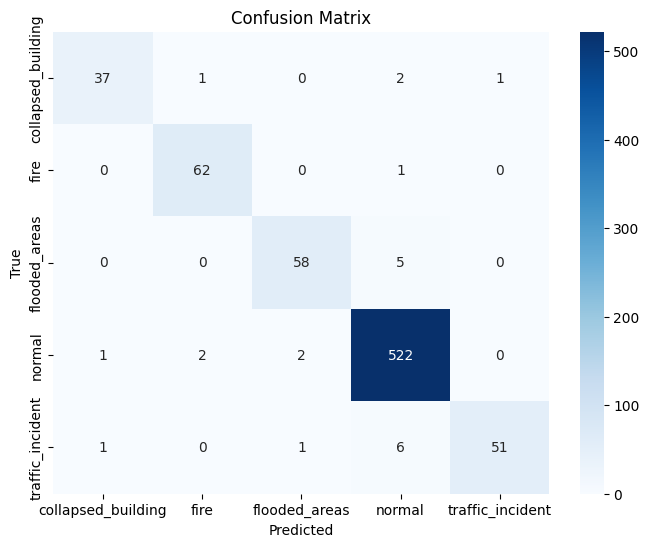

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


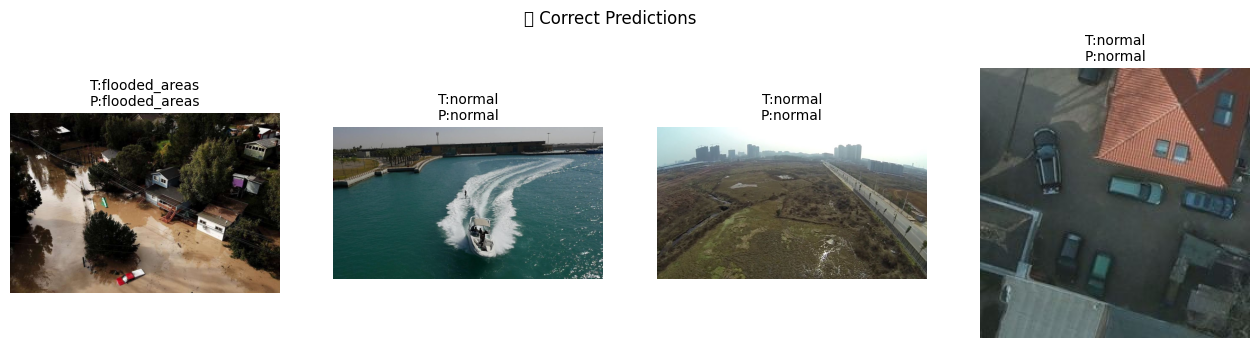

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


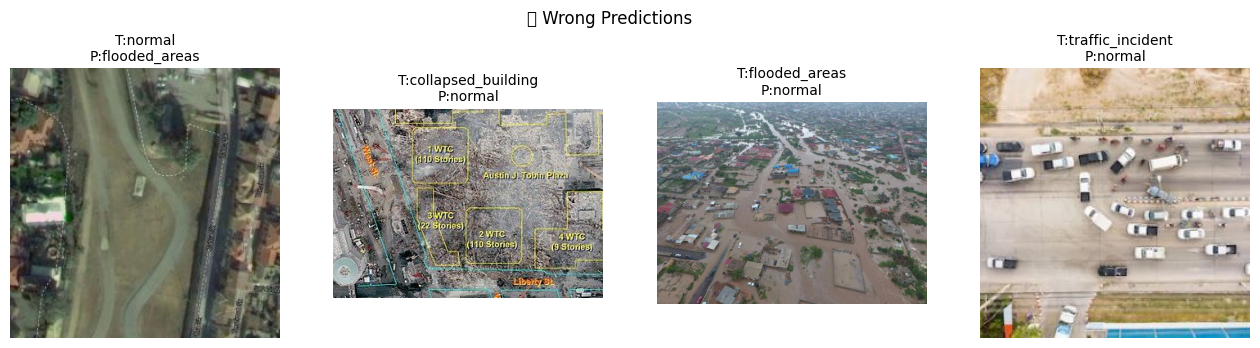

In [23]:
results = evaluate_completion_model_with_metrics(Final_model, val_loader, processor)


🔍 Evaluating with robust extraction and comprehensive metrics...


Evaluating: 100%|██████████| 155/155 [19:24<00:00,  7.52s/it]



📊 COMPREHENSIVE EVALUATION RESULTS:
🎯 Accuracy: 96.81% (2394/2473)
📈 Weighted F1 Score: 0.9680
📈 Macro F1 Score: 0.9421
📈 Micro F1 Score: 0.9681
⏱️ Avg Processing Time per Sample: 0.4711 sec

🔍 CONFUSION MATRIX:
       coll   fire   floo   norm   traf
coll     98      1      0      4      0
fire      0    207      0      2      0
floo      1      1    194     14      1
norm      9      3     13   1723      8
traf      5      2      1     14    172

📋 DETAILED CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

collapsed_building     0.8673    0.9515    0.9074       103
              fire     0.9673    0.9904    0.9787       209
     flooded_areas     0.9327    0.9194    0.9260       211
            normal     0.9806    0.9812    0.9809      1756
  traffic_incident     0.9503    0.8866    0.9173       194

          accuracy                         0.9681      2473
         macro avg     0.9396    0.9458    0.9421      2473
      weighted avg     0.9683 

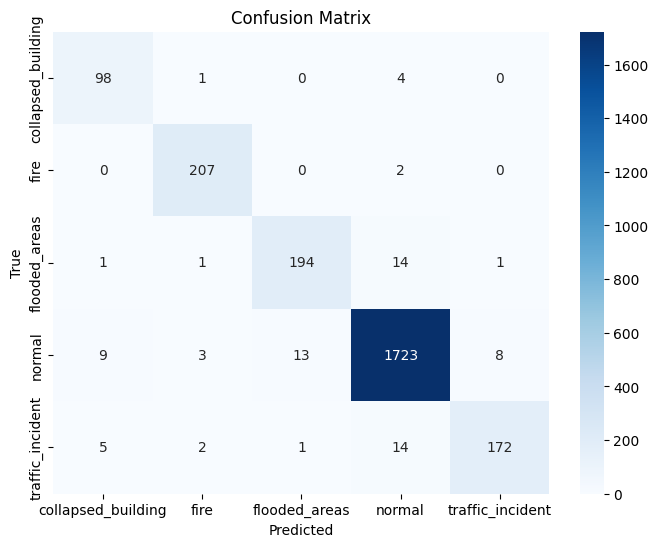

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


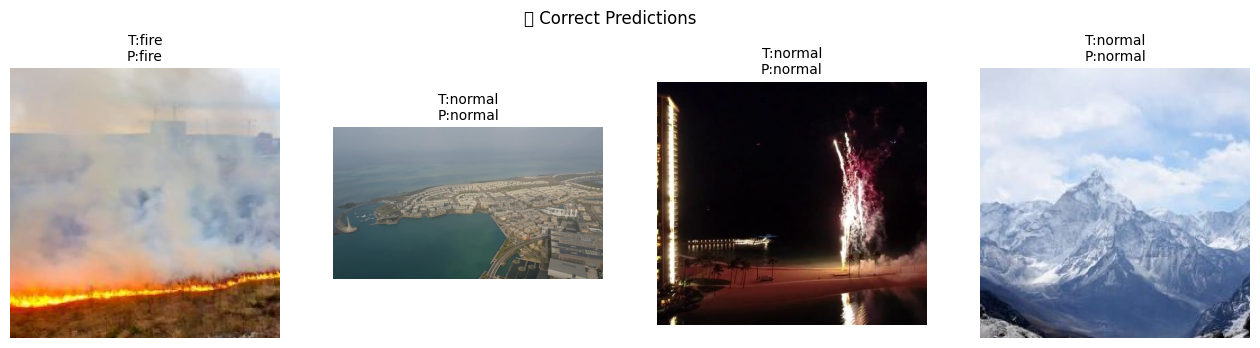

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


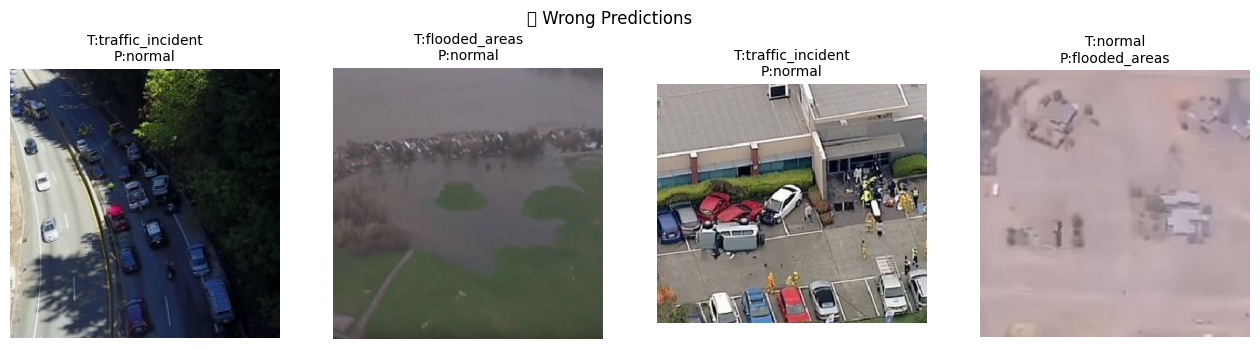

In [22]:
results = evaluate_completion_model_with_metrics(Final_model, test_loader, processor)